#**Team-06**

#Factorization Meets the Neighborhood: a Multifaceted Collaborative Filtering Model(Research Paper Implementation)
---


**Vrishmi Parikh (202318013)**

**Mahmood Topiwala (202318030)**

**Anurag Shukla (202318039)**

**Tanaz Pathan (202318056)**


**Data Preparation**

In [ ]:
import tarfile

# Open the .tar.gz file
tar_ref = tarfile.open('/content/drive/MyDrive/nf_prize_dataset.tar.gz', 'r:gz')

# Extract all contents to a specified directory
tar_ref.extractall('/content')

# Close the file
tar_ref.close()


In [ ]:
path = "/content"

from itertools import groupby
from operator import itemgetter
import pickle
import os
from sklearn.preprocessing import StandardScaler
import numpy as np


def compute_sparse_correlation_matrix(A):
    scaler = StandardScaler(with_mean=False)
    scaled_A = scaler.fit_transform(A)  # Assuming A is a CSR or CSC matrix
    corr_matrix = (1/scaled_A.shape[0]) * (scaled_A.T @ scaled_A)
    return corr_matrix

def pre_processing(mat, mat_file):
    # Create bu and bi indexes
    # bi_index is a list with a size equal to the number of users
    #    the jth element is a list storing the indexes of movies rated by user j
    # bu_index is the same but storing the indexes of users whose rating is
    #    available for a movie
    # These indexes will help to the algorithms computation

    shape = str(mat.shape[0])+"_"+str(mat.shape[1])
    bu_index_file = mat_file+"_bu_index_"+shape+".data"
    bi_index_file = mat_file+"_bi_index_"+shape+".data"

    if not (os.path.isfile(bu_index_file) and os.path.isfile(bi_index_file)):
        #mat = io.loadmat(mat_file)['X']
        """mat = mat[1:5000,1:5000]
        mat = mat[mat.getnnz(1)>0][:,mat.getnnz(0)>0]"""

        print("Pre-processing...")
        mat_nonzero = mat.nonzero()
        """cx = mat.tocoo()
        bi_index = [[]]*mat.shape[0]
        bu_index = [[]]*mat.shape[1]
        for i,j,v in zip(cx.row, cx.col, cx.data):
          bi_index[i].append(j)
          bu_index[j].append(i)
        print(bi_index[0])"""

        print("   make bi indexes...")
        bi_index = []
        for k, g in groupby(zip(mat_nonzero[0], mat_nonzero[1]), itemgetter(0)):
          to_add = list(map(lambda x:int(x[1]), list(g)))
          bi_index.append(to_add)

        print("   make bu indexes...")
        bu_index = []
        indexes = np.argsort(mat_nonzero[1])
        for k, g in groupby(zip(mat_nonzero[1][indexes], mat_nonzero[0][indexes]), itemgetter(0)):
          to_add = list(map(lambda x:int(x[1]), list(g)))
          bu_index.append(to_add)

        with open(bi_index_file, "wb") as fp:
            pickle.dump(bi_index, fp)
        with open(bu_index_file, "wb") as fp:
            pickle.dump(bu_index, fp)
    else:
        with open(bi_index_file, "rb") as fp:
            bi_index = pickle.load(fp)
        with open(bu_index_file, "rb") as fp:
            bu_index = pickle.load(fp)

    print("Pre-processing done.")
    return bu_index, bi_index

**Data Compilation**

In [ ]:
import sys  # Importing the sys module for system-specific parameters and functions
import os  # Importing the os module for interacting with the operating system
from scipy.sparse import dok_matrix, csr_matrix, lil_matrix  # Importing specific sparse matrix types from SciPy
from scipy import io  # Importing input/output functions from SciPy
import tarfile  # Importing the tarfile module to manipulate tar archives
import numpy as np  # Importing the numpy library for numerical computing


#################################################
total_no_users = 2649429  # Total number of users in the dataset
total_no_movies = 17770  # Total number of movies in the dataset

def process_content(content, D):
    """
    Process the content of a file and update the sparse matrix D.

    Args:
    content (str): The content of the file.
    D (scipy.sparse.lil_matrix): The sparse matrix to update.

    Returns:
    scipy.sparse.lil_matrix: The updated sparse matrix.
    """
    lines = content.split("\n")  # Splitting the content into lines
    id_movie = int(lines[0][:-1]) - 1  # Extracting the movie ID
    for i in range(1, len(lines)):
        if lines[i] != '':
            line = lines[i].split(",")
            id_user = int(line[0]) - 1  # Extracting the user ID
            rating = int(line[1])  # Extracting the rating
            D[id_user, id_movie] = rating  # Updating the matrix with the rating
    return D


def rating_compiler(folder_name, out_path):
    """
    Compile ratings from individual files in a folder into a single sparse matrix.

    Args:
    folder_name (str): Path to the folder containing individual rating files.
    out_path (str): Output path for the compiled sparse matrix.
    """
    D = lil_matrix((total_no_users, total_no_movies), dtype=np.uint8)  # Initialize a sparse matrix
    res_listdir = os.listdir(folder_name)  # Get the list of files in the folder
    number = len(res_listdir)  # Get the total number of files
    i = 0
    for f in res_listdir:
        if os.path.isfile(folder_name+f):
            if i % 100 == 0:
                print(i, " / ", number)
            myfile = open(folder_name+f)
            content = myfile.read()
            myfile.close()
            D = process_content(content, D)  # Process the content of each file and update the matrix
        i += 1
    D = csr_matrix(D)  # Convert the matrix to Compressed Sparse Row format
    io.savemat(out_path, {'X': D})  # Save the matrix to a .mat file


def rating_compiler2(tar_name, out_path):
    """
    Compile ratings from individual files in a tar archive into a single sparse matrix.

    Args:
    tar_name (str): Path to the tar archive.
    out_path (str): Output path for the compiled sparse matrix.
    """
    D = lil_matrix((total_no_users, total_no_movies), dtype=np.uint8)  # Initialize a sparse matrix
    tar = tarfile.open(tar_name)  # Open the tar archive
    res_getmembers = tar.getmembers()  # Get the list of members (files) in the archive
    number = len(res_getmembers)  # Get the total number of members
    i = 0
    for member in res_getmembers:
        f = tar.extractfile(member)  # Extract the file from the archive
        if f is not None:
            if i % 100 == 0:
                print(i, " / ", number)
            content = f.read()
            f.close()
            D = process_content(content.decode(), D)  # Process the content of each file and update the matrix
        i += 1
    tar.close()  # Close the tar archive
    D = csr_matrix(D, dtype=np.float64)  # Convert the matrix to Compressed Sparse Row format
    io.savemat(out_path, {'X': D})  # Save the matrix to a .mat file


def extract_T_and_R(D_file_name, file_name, out_T_path, out_R_path):
    """
    Extract matrices T and R from the full dataset matrix D based on a list of selected users and movies.

    Args:
    D_file_name (str): Path to the full dataset matrix file.
    file_name (str): Path to the file containing the list of selected users and movies.
    out_T_path (str): Output path for the matrix T.
    out_R_path (str): Output path for the matrix R.
    """
    D = io.loadmat(D_file_name)['X']  # Load the full dataset matrix
    myfile = open(file_name)
    content = myfile.read()
    myfile.close()
    lines = content.split("\n")  # Split the content into lines
    users, movies = set(), set()
    for line in lines:
        if line != '':
            line_split = line.split(":")
            if len(line_split) == 2:
                # Movie id
                movies.add(int(line_split[0]) - 1)  # Add the movie ID to the set
            else:
                # User id
                users.add(int(line_split[0]) - 1)  # Add the user ID to the set
    T = D[list(users), :]  # Extract matrix T based on selected users
    T = T[:, list(movies)]  # Extract matrix T based on selected movies
    io.savemat(out_T_path, {'X': T})  # Save matrix T to a .mat file

    movies2 = set(range(total_no_movies))
    movies2 = movies2.difference(movies)  # Get the set difference to find movies not selected
    users2 = set(range(total_no_users))
    users2 = users2.difference(users)  # Get the set difference to find users not selected

    R = D[list(users2), :]  # Extract matrix R based on unselected users
    R = R[:, list(movies2)]  # Extract matrix R based on unselected movies
    io.savemat(out_R_path, {'X': R})  # Save matrix R to a .mat file


#################################################
if __name__ == "__main__":
    rating_compiler2(path+"/download/training_set.tar", path+"/D.mat")
    #extract_T_and_R(path+"/D.mat", path+"/download/qualifying.txt", path+"/T.mat", path+"/R.mat")
    extract_T_and_R(path+"/D.mat", path+"/download/probe.txt", path+"/T.mat", path+"/R.mat")


100  /  17771
200  /  17771
300  /  17771
400  /  17771
500  /  17771
600  /  17771
700  /  17771
800  /  17771
900  /  17771
1000  /  17771
1100  /  17771
1200  /  17771
1300  /  17771
1400  /  17771
1500  /  17771
1600  /  17771
1700  /  17771
1800  /  17771
1900  /  17771
2000  /  17771
2100  /  17771
2200  /  17771
2300  /  17771
2400  /  17771
2500  /  17771
2600  /  17771
2700  /  17771
2800  /  17771
2900  /  17771
3000  /  17771
3100  /  17771
3200  /  17771
3300  /  17771
3400  /  17771
3500  /  17771
3600  /  17771
3700  /  17771
3800  /  17771
3900  /  17771
4000  /  17771
4100  /  17771
4200  /  17771
4300  /  17771
4400  /  17771
4500  /  17771
4600  /  17771
4700  /  17771
4800  /  17771
4900  /  17771
5000  /  17771
5100  /  17771
5200  /  17771
5300  /  17771
5400  /  17771
5500  /  17771
5600  /  17771
5700  /  17771
5800  /  17771
5900  /  17771
6000  /  17771
6100  /  17771
6200  /  17771
6300  /  17771
6400  /  17771
6500  /  17771
6600  /  17771
6700  /  17771
6800

In [ ]:
import pandas as pd
from scipy import io

# Load the T.mat file
data_D = io.loadmat('D.mat')

# Extract the matrix from the loaded data
matrix = data_D['X']

# Convert the matrix to a pandas DataFrame
df = pd.DataFrame.sparse.from_spmatrix(matrix)

# Display the DataFrame

df


,0,1,2,3,4,5,6,7,8,9,...,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
from scipy import io

# Load the T.mat file
data = io.loadmat('T.mat')

# Extract the matrix from the loaded data
matrix = data['X']

# Convert the matrix to a pandas DataFrame
df = pd.DataFrame.sparse.from_spmatrix(matrix)

# Display the DataFrame

df


,0,1,2,3,4,5,6,7,8,9,...,16928,16929,16930,16931,16932,16933,16934,16935,16936,16937
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
16933    0
16934    0
16935    0
16936    0
16937    0
Length: 16938, dtype: int64

In [ ]:
import pandas as pd
from scipy import io

# Load the T.mat file
data_R = io.loadmat('R.mat')

# Extract the matrix from the loaded data
matrix = data_R['X']

# Convert the matrix to a pandas DataFrame
R_df = pd.DataFrame.sparse.from_spmatrix(matrix)

# Display the DataFrame

R_df


,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2186567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2186568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2186569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd

# Check if user with ID 133 has rated any movies
if df.loc[133].sum() > 0:
    print("User 133 has rated movies.")
else:
    print("User 133 has not rated any movies.")


User 133 has rated movies.


In [ ]:
import pandas as pd

# Get the ratings for user 133
user_133_ratings = df.loc[133]

# Find the indices (movie IDs) where the user has rated
rated_movies_indices = user_133_ratings[user_133_ratings > 0].index

# Print the movies that user 133 has rated
print("Movies rated by user 133:")
print(rated_movies_indices)


Movies rated by user 133:
Index([   27,    54,    57,    76,   117,   142,   147,   190,   269,   272,
       ...
       17498, 17507, 17512, 17557, 17559, 17588, 17620, 17624, 17702, 17761],
      dtype='int64', length=737)


In [ ]:
user_133_ratings = df.loc[133, 76]

# Print the ratings
print("Ratings of user 133 for the movie:")
print(user_133_ratings)

Ratings of user 133 for the movie:
4.0


**1. Baseline Estimates**

In [ ]:

from scipy import io, sparse
import numpy as np



#################################################
def compute_loss(mat, mu, bu, bi, l_reg=0.02):
  loss = 0

  no_users_entries = np.array((mat != 0).sum(1)).T.ravel()
  bu_rep = np.repeat(bu.ravel(), no_users_entries)

  no_movies_entries = np.array((mat != 0).sum(0)).ravel()
  bi_rep = np.repeat(bi.ravel(), no_movies_entries)

  temp_mat = sparse.csc_matrix(mat).copy()
  temp_mat.data[:] -= bi_rep
  temp_mat.data[:] -= mu
  temp_mat = sparse.coo_matrix(temp_mat)
  temp_mat = sparse.csr_matrix(temp_mat)
  temp_mat.data[:] -= bu_rep

  loss = (temp_mat.data[:] ** 2).sum()

  loss_reg = l_reg * ((bu**2).sum() + (bi**2).sum())
  #loss += loss_reg

  return loss, loss+loss_reg

def baseline_estimator(mat, mat_file, l_reg=0.02, learning_rate=0.0000025):
  # subsample the matrix to make computation faster
  mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
  mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

  print(mat.shape)
  no_users = mat.shape[0]
  no_movies = mat.shape[1]

  bu_index, bi_index = pre_processing(mat, mat_file)

  bu = np.random.rand(no_users,1)  * 2 - 1
  bi = np.random.rand(1,no_movies) * 2 - 1
  #bu = np.zeros((no_users,1))
  #bi = np.zeros((1,no_movies))

  mu = mat.data[:].mean()
  mat_sum1 = mat.sum(1)
  mat_sum0 = mat.sum(0)
  n = mat.data[:].shape[0]
  no_users_entries = np.array((mat != 0).sum(1))
  no_movies_entries = np.array((mat != 0).sum(0))

  # Train
  print("Train...")
  n_iter = 200
  for it in range(n_iter):

    #bi_sum = bi[bi_index].sum(1).reshape((no_users,1))
    #bu_sum = bu.ravel()[bu_index].sum(0).reshape((1,no_movies))

    bi_sum = np.array(list(map(lambda x:bi.ravel()[x].sum(), bi_index))).reshape((no_users,1))
    bu_sum = np.array(list(map(lambda x:bu.ravel()[x].sum(), bu_index))).reshape((1,no_movies))

    # Vectorized operations
    bu_gradient = - 2.0 * (mat_sum1 - no_users_entries  * mu - no_users_entries  * bu - bi_sum) + 2.0 * l_reg * bu
    bu -= learning_rate * bu_gradient

    bi_gradient = - 2.0 * (mat_sum0 - no_movies_entries * mu - no_movies_entries * bi - bu_sum) + 2.0 * l_reg * bi
    bi -= learning_rate * bi_gradient

    if it % 10 == 0:
      print("compute loss...")
      print(compute_loss(mat, mu, bu, bi, l_reg=l_reg))

  return bu, bi
#################################################



if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    baseline_estimator(mat, mat_file)

(1542, 111)
Pre-processing...
   make bi indexes...
   make bu indexes...
Pre-processing done.
Train...
compute loss...
(6795.411025144216, 6806.739570722432)
compute loss...
(6690.852175881218, 6702.175321348293)
compute loss...
(6594.25853430532, 6605.5764553957715)
compute loss...
(6504.960006596772, 6516.272864673211)
compute loss...
(6422.3439790573775, 6433.651922357002)
compute loss...
(6345.8503637638805, 6357.153528536447)
compute loss...
(6274.967071799976, 6286.26558334668)
compute loss...
(6209.225877151903, 6220.519850773774)
compute loss...
(6148.1986375399165, 6159.488179403589)
compute loss...
(6091.493841370171, 6102.779049298205)
compute loss...
(6038.753452652229, 6050.034416844546)
compute loss...
(5989.650028158421, 6000.926831850846)
compute loss...
(5943.8840833223585, 5955.156803387722)
compute loss...
(5901.181685403174, 5912.450392899991)
compute loss...
(5861.292254296137, 5872.557014969412)
compute loss...
(5823.986553064273, 5835.247427802597)
compute loss.

In [ ]:
def compute_predicted_ratings(bu, bi, mu):
    # Reshape bu and bi to match each other's shapes
    bu = np.tile(bu, (1, bi.shape[1]))
    bi = np.tile(bi, (bu.shape[0], 1))

    # Compute the predicted ratings
    predicted_ratings = mu + bu + bi

    # Clip predicted ratings to [1, 5] range
    predicted_ratings = np.clip(predicted_ratings, 1, 5)

    return predicted_ratings

if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    bu, bi = baseline_estimator(mat, mat_file)

    # Compute the global mean
    mu = mat.data.mean()

    # Compute predicted ratings
    predicted_ratings = compute_predicted_ratings(bu, bi, mu)

    # Print the shape of predicted ratings
    print("Shape of predicted ratings:", predicted_ratings.shape)

    # Print the predicted ratings
    print("Predicted ratings:")
    print(predicted_ratings)


(1542, 111)
Pre-processing done.
Train...
compute loss...
(6385.625087921193, 6396.478812017747)
compute loss...
(6355.461884660853, 6366.310898756282)
compute loss...
(6325.940887566455, 6336.785242690217)
compute loss...
(6297.044160781348, 6307.883906729213)
compute loss...
(6268.754447046634, 6279.589632417584)
compute loss...
(6241.055130705574, 6251.885802937279)
compute loss...
(6213.93020334828, 6224.75640875121)
compute loss...
(6187.364231883197, 6198.186015673461)
compute loss...
(6161.342328839911, 6172.15973517087)
compute loss...
(6135.850124724364, 6146.663196717091)
compute loss...
(6110.873742262613, 6121.682522035259)
compute loss...
(6086.399772383067, 6097.204301079185)
compute loss...
(6062.415251799768, 6073.215569615633)
compute loss...
(6038.907642070794, 6049.703788281795)
compute loss...
(6015.86481001643, 6026.656823002544)
compute loss...
(5993.275009391378, 6004.062926661799)
compute loss...
(5971.126863714104, 5981.910721931037)
compute loss...
(5949.40935

In [ ]:
# Example user and movie IDs
user_id = 133
movie_id = 76

# Extract the predicted rating for the specified user and movie
predicted_rating = predicted_ratings[user_id, movie_id]

print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating}")


Predicted rating for user 133 on movie 76: 3.5897852190368917


In [ ]:
import numpy as np

# Calculate the squared error
squared_error = (predicted_rating - user_133_ratings) ** 2

# Calculate RMSE
rmse = np.sqrt(squared_error)

print("RMSE for the Baseline Estimate Model for a User ID 133:", rmse)


RMSE for the Baseline Estimate Model for a User ID 133: 0.41021478096310826


**2. Correlation-Based Neighbourhood Model**

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt
from time import time



#################################################
# Non-vectorized way (iterate through each r_ui)
#################################################
def predict_r_ui(mat, u, i, mu, S, Sk_iu, baseline_bu, baseline_bi):
  bui = mu + baseline_bu[u] + baseline_bi[0, i]
  buj = mu + baseline_bu[u] + baseline_bi[0, Sk_iu]
  return bui + 1 / S[i, Sk_iu].sum() * (S[i, Sk_iu].toarray().ravel() * (mat[u, Sk_iu].toarray().ravel() - buj)).sum()

def correlation_based_neighbourhood_model(mat, mat_file, l_reg2=100.0, k=250):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for test
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    #bu_index, bi_index = pre_processing(mat, mat_file)

    mu = mat.data[:].mean()

    # Compute similarity matrix
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    # Computation
    print("Computation...")
    n_iter = 200
    cx = mat.tocoo()
    r_ui_mat = []
    for u,i,v in zip(cx.row, cx.col, cx.data):
        Sk_iu = np.flip(np.argsort(S[i,].toarray()))[:k].ravel()
        r_ui = predict_r_ui(mat, u, i, mu, S, Sk_iu, baseline_bu, baseline_bi)
        r_ui_mat.append((u, i, r_ui[0]))

    data = list(map(lambda x: x[2], r_ui_mat))
    col = list(map(lambda x: x[1], r_ui_mat))
    row = list(map(lambda x: x[0], r_ui_mat))
    r_ui_pred = sparse.csr_matrix((data, (row, col)), shape=mat.shape)

    print((mat - r_ui_pred).sum())

    return r_ui_pred

#################################################


if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    correlation_based_neighbourhood_model(mat, mat_file)


(1542, 111)
Computation...
10114.624280999902


**3. Correlation-Based Neighbourhood Model with Implicit Feedback**

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt
from time import time



# Through all this code Rk_iu and Nk_iu are the same since implicit matrix is
#    made from the rating matrix without additional information (i.e. indexes of
#    non-zero elements are the same therefore neighbors too).


#################################################
# Non-vectorized way (iterate through each r_ui)
#################################################
def predict_r_ui_newmodel(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi):
    buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
    Rk_iu_sum = np.multiply((mat[u, Rk_iu] - buj), wij[i][Rk_iu]).sum()
    Nk_iu_sum = cij[i][Rk_iu].sum()
    return mu + bu[u] + bi[0, i] + Rk_iu_sum / sqrt(len(Rk_iu)) + Nk_iu_sum / sqrt(len(Nk_iu))

def compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi)

def compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, l_reg=0.002):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi)
        Rk_iu_sum = (wij[i][Rk_iu] ** 2).sum()
        Nk_iu_sum = (cij[i][Rk_iu] ** 2).sum()
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg * ((bu ** 2).sum() + (bi ** 2).sum() + Rk_iu_sum + Nk_iu_sum)

    return loss, loss+loss_reg

def correlation_based_implicit_neighbourhood_model(mat, mat_file, l_reg=0.002, gamma=0.005, l_reg2=100.0, k=250):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for test
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    bu_index, bi_index = pre_processing(mat, mat_file)

    # Init parameters
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    wij = np.random.rand(no_movies, no_movies) * 2 - 1
    cij = np.random.rand(no_movies, no_movies) * 2 - 1

    mu = mat.data[:].mean()

    # Compute similarity matrix
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    # Train
    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        t0 = time()
        for u,i,v in zip(cx.row, cx.col, cx.data):
            #Rk_iu = Nk_iu = bi_index[u]
            Rk_iu = Nk_iu = np.flip(np.argsort(S[i,].toarray()))[:k].ravel()
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi)

            bu[u] += gamma * (e_ui - l_reg * bu[u])
            bi[0, i] += gamma * (e_ui - l_reg * bi[0, i])

            buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
            wij[i][Rk_iu] += gamma * ( 1 / sqrt(len(Rk_iu)) * e_ui * (mat[u, Rk_iu].toarray().ravel() - buj) - l_reg * wij[i][Rk_iu] )
            cij[i][Nk_iu] += gamma * ( 1 / sqrt(len(Nk_iu)) * e_ui - l_reg * cij[i][Nk_iu] )
        gamma *= 0.99

        if it % 10 == 0:
          t1 = time()
          print(it, "\ ", n_iter, "(%.2g sec)" % (t1 - t0))
          print("compute loss...")
          print(compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, l_reg=l_reg))

    return bu, bi, wij, cij
#################################################


#################################################
# Vectorized way (in work)
# (Actually this version is faster but updates e_ui
# less frequently making it less accurate for the
# gradient descent)
#################################################
def compute_e_vectorized(mat, mu, bu, bi, Rk, wij, Nk, cij, baseline_bu, baseline_bi):
    # Rk and Nk are list of tuple (u, i, Rk_iu/Nk_iu)

    no_users_entries = np.array((mat != 0).sum(1)).T.ravel()
    bu_rep = np.repeat(bu.ravel(), no_users_entries)

    no_movies_entries = np.array((mat != 0).sum(0)).ravel()
    bi_rep = np.repeat(bi.ravel(), no_movies_entries)

    temp_mat = sparse.csc_matrix(mat).copy()
    temp_mat.data[:] -= mu
    temp_mat.data[:] -= bi_rep
    Rk_sum = np.array(list(map(lambda x : ( (mat[x[0], x[2]].toarray().ravel() \
                                           - (mu + baseline_bu[x[0]] + baseline_bi[0, x[2]])) \
                                           * wij[x[1]][x[2]] ).sum() / sqrt(len(x[2])), Rk)))
    temp_mat.data[:] -= Rk_sum
    Nk_sum = np.array(list(map(lambda x : cij[x[1]][x[2]].sum() / sqrt(len(x[2])), Nk)))
    temp_mat.data[:] -= Nk_sum
    temp_mat = sparse.coo_matrix(temp_mat)
    temp_mat = sparse.csr_matrix(temp_mat)
    temp_mat.data[:] -= bu_rep

    return temp_mat

def compute_loss_vectorized(mat, mu, bu, bi, Rk, wij, Nk, cij, baseline_bu, baseline_bi, l_reg=0.002):
    no_nonzero_element = np.array((mat != 0).sum())
    loss = (compute_e_vectorized(mat, mu, bu, bi, Rk, wij, Nk, cij, baseline_bu, baseline_bi).data[:] ** 2).sum()
    loss_reg = l_reg * np.array(list(map(lambda x : (cij[x[1]][x[2]] ** 2).sum(), Nk))).sum()
    loss_reg += l_reg * np.array(list(map(lambda x : (wij[x[1]][x[2]] ** 2).sum(), Rk))).sum()
    loss_reg += no_nonzero_element * l_reg * (bu ** 2).sum()
    loss_reg += no_nonzero_element * l_reg * (bi ** 2).sum()

    return loss, loss+loss_reg

def correlation_based_implicit_neighbourhood_model_vectorized(mat, mat_file, l_reg=0.002, gamma=0.005, l_reg2=100.0, k=250):
    gamma /= 100

    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]
    no_users_entries = np.array((mat != 0).sum(1))
    no_movies_entries = np.array((mat != 0).sum(0))

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for testing
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    bu_index, bi_index = pre_processing(mat, mat_file)

    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    wij = np.random.rand(no_movies, no_movies) * 2 - 1
    cij = np.random.rand(no_movies, no_movies) * 2 - 1

    mu = mat.data[:].mean()

    # Compute similarity matrix
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    Rk = []
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        Rk.append((u, i, np.flip(np.argsort(S[i,].toarray()))[:k].ravel()))

    # Train
    print("Train...")
    n_iter = 200
    for it in range(n_iter):
        t0 = time()

        e = compute_e_vectorized(mat, mu, bu, bi, Rk, wij, Rk, cij, baseline_bu, baseline_bi)
        # Vectorized operations
        bu += gamma * (e.sum(1) - no_users_entries * l_reg * bu)
        bi += gamma * (e.sum(0) - no_movies_entries * l_reg * bi)

        # TODO: vectorize the following
        for u, i, Rk_iu in Rk:
            Nk_iu = Rk_iu
            e_ui = e[u, i]
            buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
            wij[i][Rk_iu] += gamma * ( 1 / sqrt(len(Rk_iu)) * e_ui * (mat[u, Rk_iu].toarray().ravel() - buj) - l_reg * wij[i][Rk_iu] )
            cij[i][Nk_iu] += gamma * ( 1 / sqrt(len(Nk_iu)) * e_ui - l_reg * cij[i][Nk_iu] )
        gamma *= 0.99

        if it % 10 == 0:
          t1 = time()
          print(it, "\ ", n_iter, "(%.2g sec)" % (t1 - t0))
          print("compute loss...")
          print(compute_loss_vectorized(mat, mu, bu, bi, Rk, wij, Rk, cij, baseline_bu, baseline_bi, l_reg=l_reg))

    return bu, bi, wij, cij
#################################################


if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    correlation_based_implicit_neighbourhood_model(mat, mat_file)
    #correlation_based_implicit_neighbourhood_model_vectorized(mat, mat_file)


(1542, 111)
Pre-processing done.
Train...


<ipython-input-53-e237adf18e5c>:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bi[0, i] += gamma * (e_ui - l_reg * bi[0, i])


0 \  200 (6.8 sec)
compute loss...
(array([5498.81172662]), array([9559.91821404]))
10 \  200 (4.7 sec)
compute loss...
(array([3317.24117512]), array([6841.28338918]))
20 \  200 (4.9 sec)
compute loss...
(array([2600.90291121]), array([5838.16702128]))
30 \  200 (4.1 sec)
compute loss...
(array([2177.03906077]), array([5235.90083425]))
40 \  200 (3.5 sec)
compute loss...
(array([1896.13059495]), array([4834.91826319]))
50 \  200 (3.5 sec)
compute loss...
(array([1696.87676655]), array([4550.67184563]))
60 \  200 (3.5 sec)
compute loss...
(array([1548.82399094]), array([4340.31799786]))
70 \  200 (4 sec)
compute loss...
(array([1435.04545887]), array([4179.67972152]))
80 \  200 (4.1 sec)
compute loss...
(array([1345.34088596]), array([4054.01808392]))
90 \  200 (5.1 sec)
compute loss...
(array([1273.17601826]), array([3953.81220341]))
100 \  200 (3.9 sec)
compute loss...
(array([1214.16278473]), array([3872.63301199]))
110 \  200 (3.4 sec)
compute loss...
(array([1165.2432559]), array(

**correlation_based_neighbourhood_model_weighted**

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt
from time import time

def predict_r_ui_wgtngbr(mat, u, i, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi):
    buj = mu + baseline_bu[u] + baseline_bi[0, Sk_iu]
    return bu[u] + bi[0, i] + np.sum(theta_ui * (mat[u, Sk_iu].toarray().ravel() - buj))

def compute_e_ui(mat, u, i, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi)

def compute_loss(mat, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi, l_reg=0.002):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi)
        loss += (mat[u, i] - r_ui_pred) ** 2

    # Regularization term
    loss_reg += l_reg * ((bu ** 2).sum() + (bi ** 2).sum() + (theta_ui ** 2).sum())

    return loss, loss + loss_reg

def correlation_based_neighbourhood_model_weighted(mat, mat_file, l_reg=0.002, gamma=0.005, k=250):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    # Initialize parameters randomly
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    theta_ui = np.random.rand(no_movies, k) * 2 - 1

    mu = mat.data[:].mean()

    # Train
    print("Training...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        t0 = time()
        for u, i, v in zip(cx.row, cx.col, cx.data):
            Sk_iu = np.flip(np.argsort(S[i, ].toarray()))[:k].ravel()
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, Sk_iu, theta_ui[i], baseline_bu, baseline_bi)

            bu[u] += gamma * (e_ui - l_reg * bu[u])
            bi[0, i] += gamma * (e_ui - l_reg * bi[0, i])

            buj = mu + baseline_bu[u] + baseline_bi[0, Sk_iu]
            theta_ui[i] += gamma * (e_ui * (mat[u, Sk_iu].toarray().ravel() - buj) - l_reg * theta_ui[i])

        gamma *= 0.99

        if it % 10 == 0:
            t1 = time()
            print("Iteration:", it, "/", n_iter, "(%.2g sec)" % (t1 - t0))
            print("Compute loss...")
            print(compute_loss(mat, mu, bu, bi, Sk_iu, theta_ui[i], baseline_bu, baseline_bi, l_reg=l_reg))

    return bu, bi, theta_ui

if __name__ == "__main__":
    mat_file = path + "/T.mat"
    mat = io.loadmat(mat_file)['X']
    correlation_based_neighbourhood_model_weighted(mat, mat_file)


**4. SVD++**

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt, isnan



#################################################
# Non-vectorized way
#################################################
def predict_r_ui_svd_more_more(mat, u, i, mu, bu, bi, qi, pu, N_u, yj):
    N_u_sum = yj[N_u].sum(0)
    return mu + bu[u] + bi[0, i] + np.dot(qi[i], (pu[u] + N_u_sum / sqrt(len(N_u))))

def compute_e_ui(mat, u, i, mu, bu, bi, qi, pu, N_u, yj):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)

def compute_loss(mat, mu, bu, bi, qi, pu, N_u, yj, l_reg6=0.005, l_reg7=0.015):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg6 * ((bu ** 2).sum() + (bi ** 2).sum())
        loss_reg += l_reg7 * ((qi[i]**2).sum() + (pu[u]**2).sum() + (yj[N_u]**2).sum())

    return loss, loss+loss_reg

def svd_more_more(mat, mat_file, gamma1=0.007, gamma2=0.007, gamma3=0.001, l_reg2=100, l_reg6=0.005, l_reg7=0.015, f=50):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    bu_index, bi_index = pre_processing(mat, mat_file)

    # Init parameters
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    qi = np.random.rand(no_movies, f) * 2 - 1
    pu = np.random.rand(no_users, f) * 2 - 1
    yj = np.random.rand(no_movies, f) * 2 - 1

    mu = mat.data[:].mean()

    # Train
    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        for u,i,v in zip(cx.row, cx.col, cx.data):
            N_u = bi_index[u]
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)

            bu[u] += gamma1 * (e_ui - l_reg6 * bu[u])
            bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])
            qi[i] += gamma2 * (e_ui * (pu[u] + 1 / sqrt(len(N_u)) * yj[N_u].sum(0)) - l_reg7 * qi[i])
            pu[u] += gamma2 * (e_ui * qi[i] - l_reg7 * pu[u])
            yj[N_u] += gamma2 * (e_ui * 1/ sqrt(len(N_u)) * qi[i] - l_reg7 * yj[N_u])
        gamma1 *= 0.9
        gamma2 *= 0.9

        if it % 10 == 0:
          print(it, "\ ", n_iter)
          print("compute loss...")
          print(compute_loss(mat, mu, bu, bi, qi, pu, N_u, yj, l_reg6=l_reg6, l_reg7=l_reg7))

    return bu, bi, qi, pu, yj
#################################################


if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    svd_more_more(mat, mat_file)


(1542, 111)
Pre-processing done.
Train...


<ipython-input-7-5d9ebb8e95c6>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])


0 \  200
compute loss...
(array([13791.37048199]), array([24791.32424838]))
10 \  200
compute loss...
(array([6959.23481364]), array([16958.51812551]))
20 \  200
compute loss...
(array([6401.33030715]), array([16191.55471676]))
30 \  200
compute loss...
(array([6241.52771747]), array([15966.57500216]))
40 \  200
compute loss...
(array([6189.01541564]), array([15892.16051591]))
50 \  200
compute loss...
(array([6171.06434054]), array([15866.66880155]))
60 \  200
compute loss...
(array([6164.84760227]), array([15857.83434017]))
70 \  200
compute loss...
(array([6162.68506636]), array([15854.7604565]))
80 \  200
compute loss...
(array([6161.93165548]), array([15853.68944773]))
90 \  200
compute loss...
(array([6161.66903248]), array([15853.31610578]))
100 \  200
compute loss...
(array([6161.57747064]), array([15853.18594113]))
110 \  200
compute loss...
(array([6161.54554611]), array([15853.14055693]))
120 \  200
compute loss...
(array([6161.53441485]), array([15853.12473261]))
130 \  200

**5. Integrated Model**

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt, isnan



# Through all this code Rk_iu and Nk_iu are the same since implicit matrix is
#    made from the rating matrix without additional information.


#################################################
# Non-vectorized way
#################################################
def predict_r_ui_integrated(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj):
    buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
    Rk_iu_sum = np.multiply((mat[u, Rk_iu] - buj), wij[i][Rk_iu]).sum()
    Nk_iu_sum = cij[i][Rk_iu].sum()
    N_u_sum = yj[N_u].sum(0)
    return mu + bu[u] + bi[0, i] + np.dot(qi[i], (pu[u] + N_u_sum / sqrt(len(N_u)))) + Rk_iu_sum / sqrt(len(Rk_iu)) + Nk_iu_sum / sqrt(len(Nk_iu))

def compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)

def compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj, l_reg6=0.005, l_reg7=0.015, l_reg8=0.015):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)
        Rk_iu_sum = (wij[i][Rk_iu] ** 2).sum()
        Nk_iu_sum = (cij[i][Rk_iu] ** 2).sum()
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg6 * ((bu ** 2).sum() + (bi ** 2).sum())
        loss_reg += l_reg8 * (Rk_iu_sum + Nk_iu_sum)
        loss_reg += l_reg7 * ((qi[i]**2).sum() + (pu[u]**2).sum() + (yj[N_u]**2).sum())

    return loss, loss+loss_reg

def integrated_model(mat, mat_file, gamma1=0.007, gamma2=0.007, gamma3=0.001, l_reg2=100, l_reg6=0.005, l_reg7=0.015, l_reg8=0.015, k=300, f=50):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for test
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    bu_index, bi_index = pre_processing(mat, mat_file)

    # Init parameters
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    wij = np.random.rand(no_movies, no_movies) * 2 - 1
    cij = np.random.rand(no_movies, no_movies) * 2 - 1
    qi = np.random.rand(no_movies, f) * 2 - 1
    pu = np.random.rand(no_users, f) * 2 - 1
    yj = np.random.rand(no_movies, f) * 2 - 1

    mu = mat.data[:].mean()
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    # Train
    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        for u,i,v in zip(cx.row, cx.col, cx.data):
            #Rk_iu = Nk_iu = bi_index[u]
            N_u = bi_index[u]
            Rk_iu = Nk_iu = np.flip(np.argsort(S[i,].toarray()))[:k].ravel()
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)

            bu[u] += gamma1 * (e_ui - l_reg6 * bu[u])
            bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])
            qi[i] += gamma2 * (e_ui * (pu[u] + 1 / sqrt(len(N_u)) * yj[N_u].sum(0)) - l_reg7 * qi[i])
            pu[u] += gamma2 * (e_ui * qi[i] - l_reg7 * pu[u])
            yj[N_u] += gamma2 * (e_ui * 1/ sqrt(len(N_u)) * qi[i] - l_reg7 * yj[N_u])
            buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
            wij[i][Rk_iu] += gamma3 * ( 1 / sqrt(len(Rk_iu)) * e_ui * (mat[u, Rk_iu].toarray().ravel() - buj) - l_reg8 * wij[i][Rk_iu] )
            cij[i][Nk_iu] += gamma3 * ( 1 / sqrt(len(Nk_iu)) * e_ui - l_reg8 * cij[i][Nk_iu] )
        gamma1 *= 0.9
        gamma2 *= 0.9
        gamma3 *= 0.9

        if it % 10 == 0:
          print(it, "\ ", n_iter)
          print("compute loss...")
          print(compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj, l_reg6=l_reg6, l_reg7=l_reg7, l_reg8=l_reg8))

    return bu, bi, qi, pu, yj, wij, cij
#################################################




if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    integrated_model(mat, mat_file)


(1542, 111)
Pre-processing done.
Train...


<ipython-input-6-cab9bb462c9a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])


0 \  200
compute loss...
(array([18479.92145893]), array([33088.92550973]))
10 \  200
compute loss...
(array([8525.58317152]), array([21951.68063541]))
20 \  200
compute loss...
(array([7870.74889857]), array([21029.50474812]))
30 \  200
compute loss...
(array([7684.53851369]), array([20758.27904793]))
40 \  200
compute loss...
(array([7623.36835439]), array([20668.3486542]))
50 \  200
compute loss...
(array([7602.45400852]), array([20637.50956313]))
60 \  200
compute loss...
(array([7595.21031083]), array([20626.81772249]))
70 \  200
compute loss...
(array([7592.6904378]), array([20623.09705742]))
80 \  200
compute loss...
(array([7591.81252043]), array([20621.80063197]))
90 \  200
compute loss...
(array([7591.50649552]), array([20621.34870446]))
100 \  200
compute loss...
(array([7591.39980168]), array([20621.19114022]))
110 \  200
compute loss...
(array([7591.3626011]), array([20621.13620256]))
120 \  200
compute loss...
(array([7591.34963022]), array([20621.11704717]))
130 \  200
c

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt, isnan



# Through all this code Rk_iu and Nk_iu are the same since implicit matrix is
#    made from the rating matrix without additional information.


#################################################
# Non-vectorized way
#################################################
def predict_r_ui_integrated(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj):
    buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
    Rk_iu_sum = np.multiply((mat[u, Rk_iu] - buj), wij[i][Rk_iu]).sum()
    Nk_iu_sum = cij[i][Rk_iu].sum()
    N_u_sum = yj[N_u].sum(0)
    return mu + bu[u] + bi[0, i] + np.dot(qi[i], (pu[u] + N_u_sum / sqrt(len(N_u)))) + Rk_iu_sum / sqrt(len(Rk_iu)) + Nk_iu_sum / sqrt(len(Nk_iu))

def compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)

def compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj, l_reg6=0.005, l_reg7=0.015, l_reg8=0.015):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)
        Rk_iu_sum = (wij[i][Rk_iu] ** 2).sum()
        Nk_iu_sum = (cij[i][Rk_iu] ** 2).sum()
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg6 * ((bu ** 2).sum() + (bi ** 2).sum())
        loss_reg += l_reg8 * (Rk_iu_sum + Nk_iu_sum)
        loss_reg += l_reg7 * ((qi[i]**2).sum() + (pu[u]**2).sum() + (yj[N_u]**2).sum())

    return loss, loss+loss_reg

def integrated_model(mat, mat_file, gamma1=0.007, gamma2=0.007, gamma3=0.001, l_reg2=100, l_reg6=0.005, l_reg7=0.015, l_reg8=0.015, k=300, f=50):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for test
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    bu_index, bi_index = pre_processing(mat, mat_file)

    # Init parameters
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    wij = np.random.rand(no_movies, no_movies) * 2 - 1
    cij = np.random.rand(no_movies, no_movies) * 2 - 1
    qi = np.random.rand(no_movies, f) * 2 - 1
    pu = np.random.rand(no_users, f) * 2 - 1
    yj = np.random.rand(no_movies, f) * 2 - 1

    mu = mat.data[:].mean()
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    # Train
    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        for u,i,v in zip(cx.row, cx.col, cx.data):
            #Rk_iu = Nk_iu = bi_index[u]
            N_u = bi_index[u]
            Rk_iu = Nk_iu = np.flip(np.argsort(S[i,].toarray()))[:k].ravel()
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)

            bu[u] += gamma1 * (e_ui - l_reg6 * bu[u])
            bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])
            qi[i] += gamma2 * (e_ui * (pu[u] + 1 / sqrt(len(N_u)) * yj[N_u].sum(0)) - l_reg7 * qi[i])
            pu[u] += gamma2 * (e_ui * qi[i] - l_reg7 * pu[u])
            yj[N_u] += gamma2 * (e_ui * 1/ sqrt(len(N_u)) * qi[i] - l_reg7 * yj[N_u])
            buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
            wij[i][Rk_iu] += gamma3 * ( 1 / sqrt(len(Rk_iu)) * e_ui * (mat[u, Rk_iu].toarray().ravel() - buj) - l_reg8 * wij[i][Rk_iu] )
            cij[i][Nk_iu] += gamma3 * ( 1 / sqrt(len(Nk_iu)) * e_ui - l_reg8 * cij[i][Nk_iu] )
        gamma1 *= 0.9
        gamma2 *= 0.9
        gamma3 *= 0.9

        if it % 10 == 0:
          print(it, "\ ", n_iter)
          print("compute loss...")
          print(compute_loss(mat, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj, l_reg6=l_reg6, l_reg7=l_reg7, l_reg8=l_reg8))

    return bu, bi, qi, pu, yj, wij, cij, mu, Rk_iu, Nk_iu, baseline_bu, baseline_bi, N_u


if __name__ == "__main__":
    mat_file = path+"/T.mat"
    mat = io.loadmat(mat_file)['X']
    bu, bi, qi, pu, yj, wij, cij, mu, Rk_iu, Nk_iu, baseline_bu, baseline_bi, N_u = integrated_model(mat, mat_file)

    # Example user and movie IDs
    user_id = 133
    movie_id = 76

    # Calculate the rating prediction for the given user and movie
    rating_prediction = predict_r_ui_integrated(mat, user_id, movie_id, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)
    print("Predicted rating for user", user_id, "and movie", movie_id, ":", rating_prediction)


(1542, 111)
Pre-processing done.
Train...


<ipython-input-24-15e84c8be0cc>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])


0 \  200
compute loss...
(array([21654.61084155]), array([36679.73762154]))
10 \  200
compute loss...
(array([10556.25880131]), array([24317.68379767]))
20 \  200
compute loss...
(array([9602.46670484]), array([23076.1997271]))
30 \  200
compute loss...
(array([9329.16001158]), array([22711.25684652]))
40 \  200
compute loss...
(array([9238.73257574]), array([22589.81902253]))
50 \  200
compute loss...
(array([9207.74975886]), array([22548.13400577]))
60 \  200
compute loss...
(array([9197.01219801]), array([22533.67808617]))
70 \  200
compute loss...
(array([9193.27616483]), array([22528.64714776]))
80 \  200
compute loss...
(array([9191.97445229]), array([22526.89412469]))
90 \  200
compute loss...
(array([9191.52069005]), array([22526.28302389]))
100 \  200
compute loss...
(array([9191.36248714]), array([22526.0699633]))
110 \  200
compute loss...
(array([9191.30732692]), array([22525.99567574]))
120 \  200
compute loss...
(array([9191.28809395]), array([22525.96977352]))
130 \  200

In [ ]:
import numpy as np

# Calculate the squared error
squared_error = (rating_prediction - user_133_ratings) ** 2

# Calculate RMSE
rmse = np.sqrt(squared_error)

print("RMSE for the Integrated Model for a User ID 133:", rmse)


RMSE for the Integrated Model for a User: [0.37240281]


In [ ]:
user_id = 45
movie_id = 100

# Calculate the rating prediction for the given user and movie
rating_prediction = predict_r_ui_integrated(mat, user_id, movie_id, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)
print("Predicted rating for user", user_id, "and movie", movie_id, ":", rating_prediction)

Predicted rating for user 45 and movie 100 : [3.46822214]


**Evaluation**

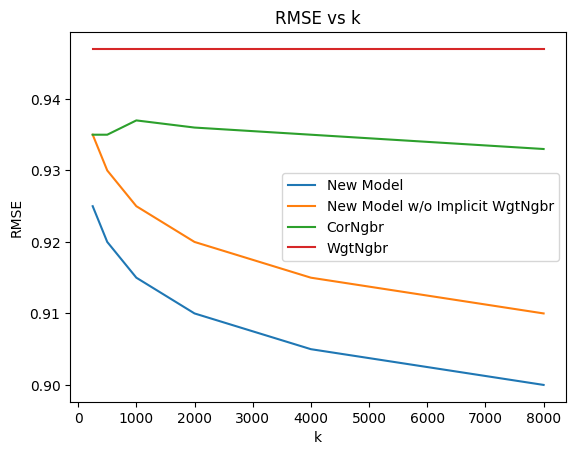

In [ ]:
import numpy as np
from scipy import io, sparse
from math import sqrt


import numpy as np
from scipy import io, sparse
from math import sqrt
from time import time

def predict_r_ui_newmodelwo(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi):
    buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
    Rk_iu_sum = np.multiply((mat[u, Rk_iu] - buj), wij[i][Rk_iu]).sum()
    return mu + bu[u] + bi[0, i] + Rk_iu_sum / sqrt(len(Rk_iu))

def compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi):
    return mat[u, i] - predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi)

def compute_loss(mat, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi, l_reg=0.002):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi)
        Rk_iu_sum = (wij[i][Rk_iu] ** 2).sum()
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg * ((bu ** 2).sum() + (bi ** 2).sum() + Rk_iu_sum)

    return loss, loss+loss_reg

def correlation_based_neighbourhood_model_without_implicit(mat, mat_file, l_reg=0.002, gamma=0.005, k=250):
    # subsample the matrix to make computation faster
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    #baseline_bu, baseline_bi = baseline_estimator(mat)
    # We should call baseline_estimator but we can init at random for test
    baseline_bu, baseline_bi = np.random.rand(no_users, 1)  * 2 - 1, np.random.rand(1, no_movies) * 2 - 1

    bu_index, bi_index = pre_processing(mat, mat_file)

    # Init parameters
    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    wij = np.random.rand(no_movies, no_movies) * 2 - 1

    mu = mat.data[:].mean()

    # Compute similarity matrix
    N = sparse.csr_matrix(mat).copy()
    N.data[:] = 1
    S = sparse.csr_matrix.dot(N.T, N)
    S.data[:] = S.data[:] / (S.data[:] + l_reg2)
    S = S * compute_sparse_correlation_matrix(mat)

    # Train
    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        t0 = time()
        for u,i,v in zip(cx.row, cx.col, cx.data):
            Rk_iu = np.flip(np.argsort(S[i,].toarray()))[:k].ravel()
            e_ui = compute_e_ui(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi)

            bu[u] += gamma * (e_ui - l_reg * bu[u])
            bi[0, i] += gamma * (e_ui - l_reg * bi[0, i])

            buj = mu + baseline_bu[u] + baseline_bi[0, Rk_iu]
            wij[i][Rk_iu] += gamma * ( 1 / sqrt(len(Rk_iu)) * e_ui * (mat[u, Rk_iu].toarray().ravel() - buj) - l_reg * wij[i][Rk_iu] )
        gamma *= 0.99

        if it % 10 == 0:
          t1 = time()
          print(it, "\ ", n_iter, "(%.2g sec)" % (t1 - t0))
          print("compute loss...")
          print(compute_loss(mat, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi, l_reg=l_reg))

    return bu, bi, wij



# Function to calculate RMSE
def calculate_rmse(actual_ratings, predicted_ratings):
    # Flatten the actual and predicted ratings matrices
    actual = actual_ratings.data
    predicted = predicted_ratings.data

    # Calculate the squared error
    squared_error = np.square(actual - predicted)

    # Calculate the mean squared error
    mean_squared_error = np.mean(squared_error)

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error)
    return rmse

# Load the Netflix dataset
mat_file = path + "/T.mat"
mat = io.loadmat(mat_file)['X']
# Initialize an empty list to store RMSE values
rmse_values_corngbr = []
rmse_values_newmodel = []
rmse_values_wgtngbr = []
rmse_values_newmodelwo = []
# Iterate over different values of k
for k in range(250, 8000):
    # Calling all the correlation-based neighborhood models function
    # Training and predicting the correlation based neighbourhood model with the current number of k value
    predicted_ratings_corngbr = correlation_based_neighbourhood_model(mat, mat_file,l_reg2=100.0, k=k)
    # Training the correlation based implicit feedback neighbourhood model with the current number of k value
    bu, bi, wij, cij = correlation_based_implicit_neighbourhood_model(mat,mat_file, k=k)
    # Predicting ratings using the trained model
    predicted_ratings_newmodel = predict_r_ui_newmodel(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi)
    # Training the correlation based without implicit feedback neighbourhood model with the current number of k value
    bu, bi, wij = correlation_based_neighbourhood_model_without_implicit(mat, mat_file, k=k)
    # Predicting ratings using the trained model
    predicted_ratings_newmodelwo = predict_r_ui_newmodelwo(mat, u, i, mu, bu, bi, Rk_iu, wij, baseline_bu, baseline_bi)
    # Training the correlation based weighted neighbourhood model with the current number of k value
    bu, bi, theta_ui = correlation_based_neighbourhood_model_weighted(mat, mat_file, k=k)
    # Predicting ratings using the trained model
    predicted_ratings_wgtngbr = predict_r_ui_wgtngbr(mat, u, i, mu, bu, bi, Sk_iu, theta_ui, baseline_bu, baseline_bi)
    # Calculate the RMSE and append it to the list
    rmse_1 = calculate_rmse(mat, predicted_ratings_corngbr)
    rmse_values_corngbr.append(rmse_1)
    rmse_2 = calculate_rmse(mat, predicted_ratings_newmodel)
    rmse_values_newmodel.append(rmse_2)
    rmse_3 = calculate_rmse(mat, predicted_ratings_newmodelwo)
    rmse_values_newmodelwo.append(rmse_3)
    rmse_4 = calculate_rmse(mat, predicted_ratings_wgtngbr)
    rmse_values_wgtngbr.append(rmse_4)

    plt.plot(k, rmse_new_model, label='New Model')
    plt.plot(k, rmse_new_model_wo, label='New Model w/o Implicit WgtNgbr')
    plt.plot(k, rmse_corngbr, label='CorNgbr')
    plt.plot(k, rmse_wgtngbr, label='WgtNgbr')

# Set labels
plt.xlabel('k')
plt.ylabel('RMSE')

# Set title
plt.title('RMSE vs k')

# Add legend
plt.legend()

# Show the plot
plt.show()


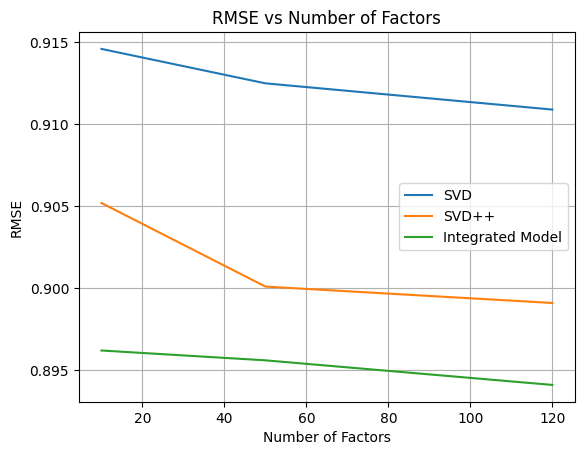

In [ ]:
##SVD and Evaluation of all the Factorization Methods
import numpy as np
from scipy import io, sparse
from math import sqrt

def predict_r_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj):
    N_u_sum = yj[N_u].sum(0)
    return mu + bu[u] + bi[0, i] + np.dot(qi[i], (pu[u] + N_u_sum / sqrt(len(N_u))))

def compute_e_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj):
    return mat[u, i] - predict_r_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)

def compute_loss_svd(mat, mu, bu, bi, qi, pu, N_u, yj, l_reg6=0.005, l_reg7=0.015):
    loss = 0
    loss_reg = 0
    cx = mat.tocoo()
    for u,i,v in zip(cx.row, cx.col, cx.data):
        r_ui_pred = predict_r_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)
        loss += (mat[u, i] - r_ui_pred) ** 2
        loss_reg += l_reg6 * ((bu ** 2).sum() + (bi ** 2).sum())
        loss_reg += l_reg7 * ((qi[i]**2).sum() + (pu[u]**2).sum() + (yj[N_u]**2).sum())

    return loss, loss+loss_reg

def svd_model_function(mat, mat_file, gamma1=0.007, gamma2=0.007, l_reg6=0.005, l_reg7=0.015, f=50):
    mat = mat[0:mat.shape[0]//128, 0:mat.shape[1]//128]
    mat = mat[mat.getnnz(1)>0][:, mat.getnnz(0)>0]

    print(mat.shape)
    no_users = mat.shape[0]
    no_movies = mat.shape[1]

    bu_index, bi_index = pre_processing(mat, mat_file)

    bu = np.random.rand(no_users, 1)  * 2 - 1
    bi = np.random.rand(1, no_movies) * 2 - 1
    qi = np.random.rand(no_movies, f) * 2 - 1
    pu = np.random.rand(no_users, f) * 2 - 1
    yj = np.random.rand(no_movies, f) * 2 - 1

    mu = mat.data[:].mean()

    print("Train...")
    n_iter = 200
    cx = mat.tocoo()
    for it in range(n_iter):
        for u,i,v in zip(cx.row, cx.col, cx.data):
            N_u = bi_index[u]
            e_ui = compute_e_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)

            bu[u] += gamma1 * (e_ui - l_reg6 * bu[u])
            bi[0, i] += gamma1 * (e_ui - l_reg6 * bi[0, i])
            qi[i] += gamma2 * (e_ui * (pu[u] + 1 / sqrt(len(N_u)) * yj[N_u].sum(0)) - l_reg7 * qi[i])
            pu[u] += gamma2 * (e_ui * qi[i] - l_reg7 * pu[u])
            yj[N_u] += gamma2 * (e_ui * 1/ sqrt(len(N_u)) * qi[i] - l_reg7 * yj[N_u])
        gamma1 *= 0.9
        gamma2 *= 0.9

        if it % 10 == 0:
          print(it, "\ ", n_iter)
          print("compute loss...")
          print(compute_loss_svd(mat, mu, bu, bi, qi, pu, N_u, yj, l_reg6=l_reg6, l_reg7=l_reg7))

    return bu, bi, qi, pu, yj



mat_file = path + "/T.mat"
mat = io.loadmat(mat_file)['X']

# Initialize an empty list to store RMSE values
rmse_values_svdpp = []
rmse_values_svd = []
rmse_values_integrated = []
# Iterate over different values of factors parameter (10 to 120)
for factors in range(10, 121):
    # Training the SVD++ model with the current number of factors
    bu, bi, qi, pu, yj = svd_more_more(mat, mat_file, f=factors)
    # Predicting ratings using the trained model
    predicted_ratings_svdpp = predict_r_ui_svd_more_more(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)
    # Training the integrated model with the current number of factors
    bu, bi, qi, pu, yj, wij, cij = integrated_model(mat, mat_file, f=factors)
    # Predicting ratings using the trained model
    predicted_ratings_integrated =  predict_r_ui_integrated(mat, u, i, mu, bu, bi, Rk_iu, wij, Nk_iu, cij, baseline_bu, baseline_bi, qi, pu, N_u, yj)
    # Training the SVD model with the current number of factors
    bu, bi, qi, pu, yj = svd_model_function(mat, mat_file, f=factors)
    # Predicting ratings using the trained model
    predicted_ratings_svd = predict_r_ui_svd(mat, u, i, mu, bu, bi, qi, pu, N_u, yj)
    # Calculate the RMSE and append it to the list
    rmse_1 = calculate_rmse(mat, predicted_ratings_svdpp)
    rmse_values_svdpp.append(rmse_1)
    rmse_2 = calculate_rmse(mat, predicted_ratings_integrated)
    rmse_values_integrated.append(rmse_2)
    rmse_3 = calculate_rmse(mat, predicted_ratings_svd)
    rmse_values_svd.append(rmse_3)

# Plot RMSE values against the factors parameter
plt.plot(range(10, 121), rmse_values_svd, label='SVD')
plt.plot(range(10, 121), rmse_values_svdpp, label='SVD++')
plt.plot(range(10, 121), rmse_values_integrated, label='Integrated Model')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Factors')
plt.legend()
plt.show()